In [13]:
#curve_44_why plots for curve 44 control test v test 24:
#Velocity: changing slowly with a few max and min (few fluctuations overall), 
#high local variability / many local fluctuations (thick curve)
#Curvature: high and many fluctuations locally and globally

In [19]:
import os
import sys
os.getcwd()

'/Users/karolinagrzeszkiewicz/robustness-tests/locomotion/tests/robustness_tests'

In [20]:
sys.path.remove('/Users/karolinagrzeszkiewicz/robustness-tests/locomotion/tests/robustness_tests')
sys.path.append('/Users/karolinagrzeszkiewicz/locomotion')

ValueError: list.remove(x): x not in list

In [21]:
## This python script contains methods for running Dynamic Time
## Warping on pairs of animal trajectories. The DTW method was
## extended from the dtw() method in the mlpy package, modified
## to take in multivariate input points, referenced as 
## extendedDTW.dtw_ext() here. Note that extendedDTW.so contains 
## the extendedDTW.dtw_ext(), which may have to be re-built for
## your system using the source code and build script provided
## along with the locomotion package.

import os
import sys
import csv
import random
import math
import operator
import numpy as np
import locomotion.extendedDTW as extendedDTW
import locomotion.write as write
import locomotion.animal as animal
from locomotion.animal import throwError
from scipy.signal import savgol_filter
from collections import defaultdict

#Static Variables
SMOOTH_RANGE_MIN = 5 #length of smoothing window in smooth()
ORDER = 5 #order of smoothing curve used in smooth()

#############################

def getDerivatives(X, axis = 0):
  """
  Computes the derivative of the series X. Returns a numpy array
  """
  dX = np.gradient(X, axis = axis)
  return dX


def smooth(X, frame_rate):
  """ Smoothes the sequence X by applying Savitzky-Golay smoothing
    :Parameters:
     X : list
    :Return:
     sX : list
  """
  r = max(SMOOTH_RANGE_MIN, int(np.ceil(frame_rate * 2.5)))
  SMOOTH_RANGE = r + 1 if r % 2 == 0 else r
  sX = savgol_filter(X,SMOOTH_RANGE,ORDER)
  return sX


def getVelocity(V):
  """
  Calculate the velocity
  :Parameters:
  V : list
  :Return:
  nV : list
  """
  nV = np.sqrt(np.sum(np.power(V, 2), axis = 0))
  return nV


def getCurvature(d1, d2, V):
  """
  Given a list of first and second derivatives, return curvature.
  Note: Currently only works for up to 2 / 3 dimensions.

  :Parameters:
  d1: numpy array
  d2: numpy array
  V: numpy array
  :Return:
  C : numpy array
  """
  if d1.shape != d2.shape:
    raise Exception("d1 and d2 should be of the same shape.")
  n_dims = d1.shape[0]
  if n_dims == 2:
    mats = np.transpose(np.array([d1,d2]), (2,0,1))
  elif n_dims == 3:
    d0 = np.ones_like(d1)
    mats = np.transpose(np.array([d0,d1,d2]), (2,0,1))
  numer = np.absolute(np.linalg.det(mats))
  denom = np.power(V,3)
  C = []
  for i in range(len(numer)):
    if denom[i] < 0.000125:
      c = 0
    else:
      c = numer[i]/denom[i]
    C.append(c)
  return C


def getCurveData( animal_obj , col_names = ['X', 'Y']):
  """ Computes the behavioural curve data such as Velocity and Curvature .
   Note that we could take in the varnames here and only compute V and C
   if they are called. However, since velocity and curvature data usually
   aren't too big, we'll blanket compute for now

   Works only 2 or 3 dimensions.

   :Parameter:
    animal_obj : animal object, initialized
    col_names : list, names of data columns.
  """
  n_dims = len(col_names)
  if n_dims < 2 or n_dims > 3:
    raise Exception("length of col_names is {}, but it should be 2 or 3.".format(n_dims))
  coords = []
  for col in col_names:
    try:
      coords.append(smooth(animal_obj.getRawVals(col), animal_obj.getFrameRate()))
    except KeyError:
      raise Exception("column name {} does not exist in animal dataset".format(col))
  coords = np.array(coords) # MM
  d1 = getDerivatives(coords, axis = 1) # MM per frame
  d1 = d1 * animal_obj.getFrameRate() # MM per second
  d2 = getDerivatives(d1, axis = 1) # MM per second per frame
  d2 = d2 * animal_obj.getFrameRate() # MM per second per second
  V = getVelocity(d1)
  C = getCurvature(d1, d2, V)

  st, et = animal_obj.getBaselineTimes()
  animal_obj.addRawVals('Velocity', V)
  animal_obj.addStats('Velocity', 'baseline', st, et)
  animal_obj.addRawVals('Curvature', C)
  animal_obj.addStats('Curvature', 'baseline', st, et)
  return d1, d2, V, C


def computeOneBDD(animal_obj_0, animal_obj_1, varnames, seg_start_time_0, seg_end_time_0, seg_start_time_1, seg_end_time_1, norm_mode, fullmode=False, outdir=None):
  """ Computes the Behavioural Distortion Distance (BDD) between 
   two animal trajectories by applying Dynamic Time Warping (DTW),
   each starting and ending at the respective time frame given in 
   the function call.

  :Parameters:
    animal_obj_0/1 : animal object
     from animal.py, initialized
    varnames : list
     variable names (str)
    seg_start/end_time_0/1 : int or float
      time in minutes
    norm_mode : str, either 'baseline' or 'spec'
     baseline mode uses the mean and standard deviation from the
     baseline observation time to normalize each variable data,
     whereas the spec mode uses the mean and standard deivation 
     from the time period specified for this comparison.
    fullmode : bool
     if True, the method first obtains the full suite of returns
     from dtw_ext and writes several path graphs
    outdir : string
     path to the output directory

  :Returns:
    bdd : float
     behavioural distortion distance
  """

  #quick sanity check for output mode
  if fullmode and outdir == None:
    throwError("Full mode requires the path to output directory")

  seg_start_frame_0 = animal.getFrameNum(animal_obj_0, seg_start_time_0)
  seg_end_frame_0 = animal.getFrameNum(animal_obj_0, seg_end_time_0)
  data_0 = animal_obj_0.getMultRawVals(varnames, seg_start_frame_0, seg_end_frame_0)

  seg_start_frame_1 = animal.getFrameNum(animal_obj_1, seg_start_time_1)
  seg_end_frame_1 = animal.getFrameNum(animal_obj_1, seg_end_time_1)
  data_1 = animal_obj_1.getMultRawVals(varnames, seg_start_frame_1, seg_end_frame_1)

  print("LOG: Applying DTW to the data from files %s and %s..." % (animal_obj_0.getName(), animal_obj_1.getName()))
  
  numVars = len(varnames)

  if norm_mode == 'baseline':
    for i in range(numVars):
      m, s = animal_obj_0.getStats(varnames[i], 'baseline')
      data_0[i] = animal.normalize(data_0[i], m, s)
      m, s = animal_obj_1.getStats(varnames[i], 'baseline')
      data_1[i] = animal.normalize(data_1[i], m, s)
  elif norm_mode == 'spec':
    for i in range(numVars):
      m, s = animal.norm(data_0[i])
      data_0[i] = animal.normalize(data_0[i], m, s)
      m, s = animal.norm(data_1[i])
      data_1[i] = animal.normalize(data_1[i], m, s)
  dist, cost, alignment = extendedDTW.dtw_ext(data_0, data_1, dist_only=False)
  #dist is the integral part of the BDD formula
  scaler = len(alignment[0]) #arclength of the alignment
  bdd = dist/scaler
  print("LOG: distance between %s and %s: %.5f" % (animal_obj_0.getName(), animal_obj_1.getName(), bdd))

  if fullmode:
    #save alignment graphs in directory specified
    write.renderAlignment(alignment, animal_obj_0, animal_obj_1, varnames, outdir)
    for i in range(numVars): 
      v = varnames[i]
      if not os.path.exists(outdir): os.makedirs(outdir)
      write.renderAlignedGraphs(data_0[i], data_1[i], alignment, animal_obj_0, animal_obj_1, v, outdir)

      #For individual plots, enable the following two lines
      #write.renderSingleAnimalGraph(data_0[i], animal_obj_0, v, outdir)
      #write.renderSingleAnimalGraph(data_1[i], animal_obj_1, v, outdir)

  return bdd



In [22]:
user_path = '/Users/karolinagrzeszkiewicz/robustness-tests/locomotion/tests/robustness_tests/results/'
#folder: FR_test_higher, FR_test_lower, density_test_higher, density_test_lower
def read_curve_44_trial_dat(folder, trial):
    #trial must be a double-digit string (also trial can be = "CTRL")
    name_of_dat = 'CRV_44_TEST_' + trial +'.dat'
    path_to_dat = user_path +folder+'/'+name_of_dat
    data = pd.read_csv(path_to_dat)
    return(data)

data_44_ctrl = read_curve_44_trial_dat("FR_test_higher", "CTRL")
data_44_fr74 = read_curve_44_trial_dat("FR_test_higher", "24")

In [23]:
import pandas as pd

In [24]:
data_44_ctrl = read_curve_44_trial_dat("FR_test_higher", "CTRL")
data_44_fr74 = read_curve_44_trial_dat("FR_test_higher", "24")

In [25]:
data_44_ctrl

,Unnamed: 0,X,Y
0,0,0,196
1,1,1,195
2,2,1,195
3,3,1,195
4,4,1,195
...,...,...,...
1435,1435,156,31
1436,1436,156,31
1437,1437,156,31
1438,1438,156,31


In [26]:
getDerivatives(data_44_ctrl.X) 

array([1. , 0.5, 0. , ..., 0. , 0.5, 1. ])

In [27]:
getDerivatives(data_44_fr74.X)

array([1. , 0.5, 0. , ..., 0.5, 0. , 0. ])

In [28]:
x_ctrl_smooth = smooth(data_44_ctrl.X, 24)
type(x_ctrl_smooth)
len(x_ctrl_smooth)
x_ctrl_smooth.tolist()
data_44_ctrl['X_smooth'] = x_ctrl_smooth

In [29]:
x_74_smooth = smooth(data_44_fr74.X, 74)
len(x_74_smooth)
x_74_smooth.tolist()
data_44_fr74['X_smooth'] = x_74_smooth
data_44_ctrl.X_smooth = smooth(data_44_ctrl.X, 24)
#check the distances between the points, this determines curvature as well

In [31]:
data_44_ctrl

,Unnamed: 0,X,Y,X_smooth
0,0,0,196,0.460216
1,1,1,195,0.594471
2,2,1,195,0.720771
3,3,1,195,0.840227
4,4,1,195,0.953865
...,...,...,...,...
1435,1435,156,31,156.018292
1436,1436,156,31,156.145436
1437,1437,156,31,156.265117
1438,1438,156,31,156.375997


In [32]:
data_44_fr74

,Unnamed: 0,X,Y,X_smooth
0,0,0,196,0.730784
1,1,1,195,0.747966
2,2,1,195,0.765906
3,3,1,195,0.784585
4,4,1,195,0.803985
...,...,...,...,...
4315,4315,156,31,156.406877
4316,4316,156,31,156.458212
4317,4317,157,31,156.509846
4318,4318,157,31,156.561794


In [33]:
y_ctrl_smooth = smooth(data_44_ctrl.Y, 24)
y_ctrl_smooth.tolist()
data_44_ctrl['Y_smooth'] = y_ctrl_smooth

x_74_smooth = smooth(data_44_fr74.X, 74)
len(x_74_smooth)
x_74_smooth.tolist()
data_44_fr74['X_smooth'] = x_74_smooth
data_44_ctrl.X_smooth = smooth(data_44_ctrl.X, 24)
#check the distances between the points, this determines curvature as well

y_74_smooth = smooth(data_44_fr74.Y, 74)
y_74_smooth.tolist()
data_44_fr74['Y_smooth'] = y_74_smooth

In [34]:
import matplotlib.pyplot as plt

In [35]:
#effect of smoothing: smaller gaps between consecutive smooth coordinates for a curve with higher fr
#check scatter plots

def curveScatterPlot_smooth(control):
    if control == True:
        data = data_44_ctrl
        label = 'trial: control '
    else:
        data = data_44_fr74
        label = 'trial: FR = 74 '
    x = data.X_smooth
    y = data.Y_smooth
    fig=plt.figure()
    ax=fig.add_axes([0,0,1,1])
    ax.scatter(x, y, color='r', s = 0.001)
    ax.set_xlabel('x_smooth')
    ax.set_ylabel('y_smooth')
    ax.set_title("Coordinate plot for Curve No. 44, " + label )
    plt.show()

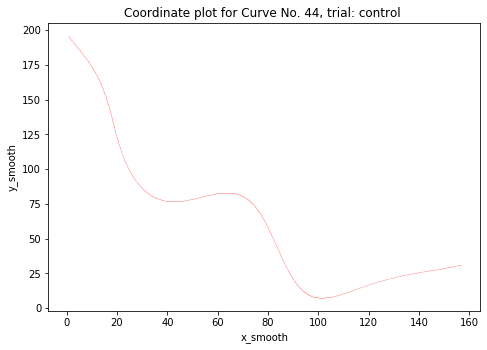

In [36]:
curveScatterPlot_smooth(True)

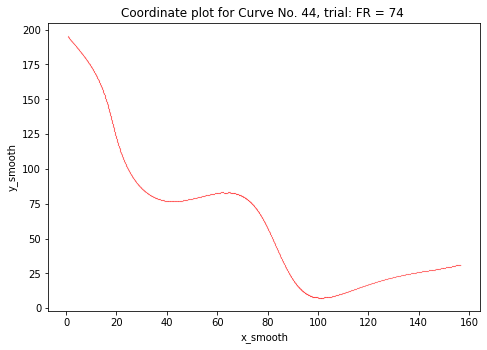

In [37]:
curveScatterPlot_smooth(False)

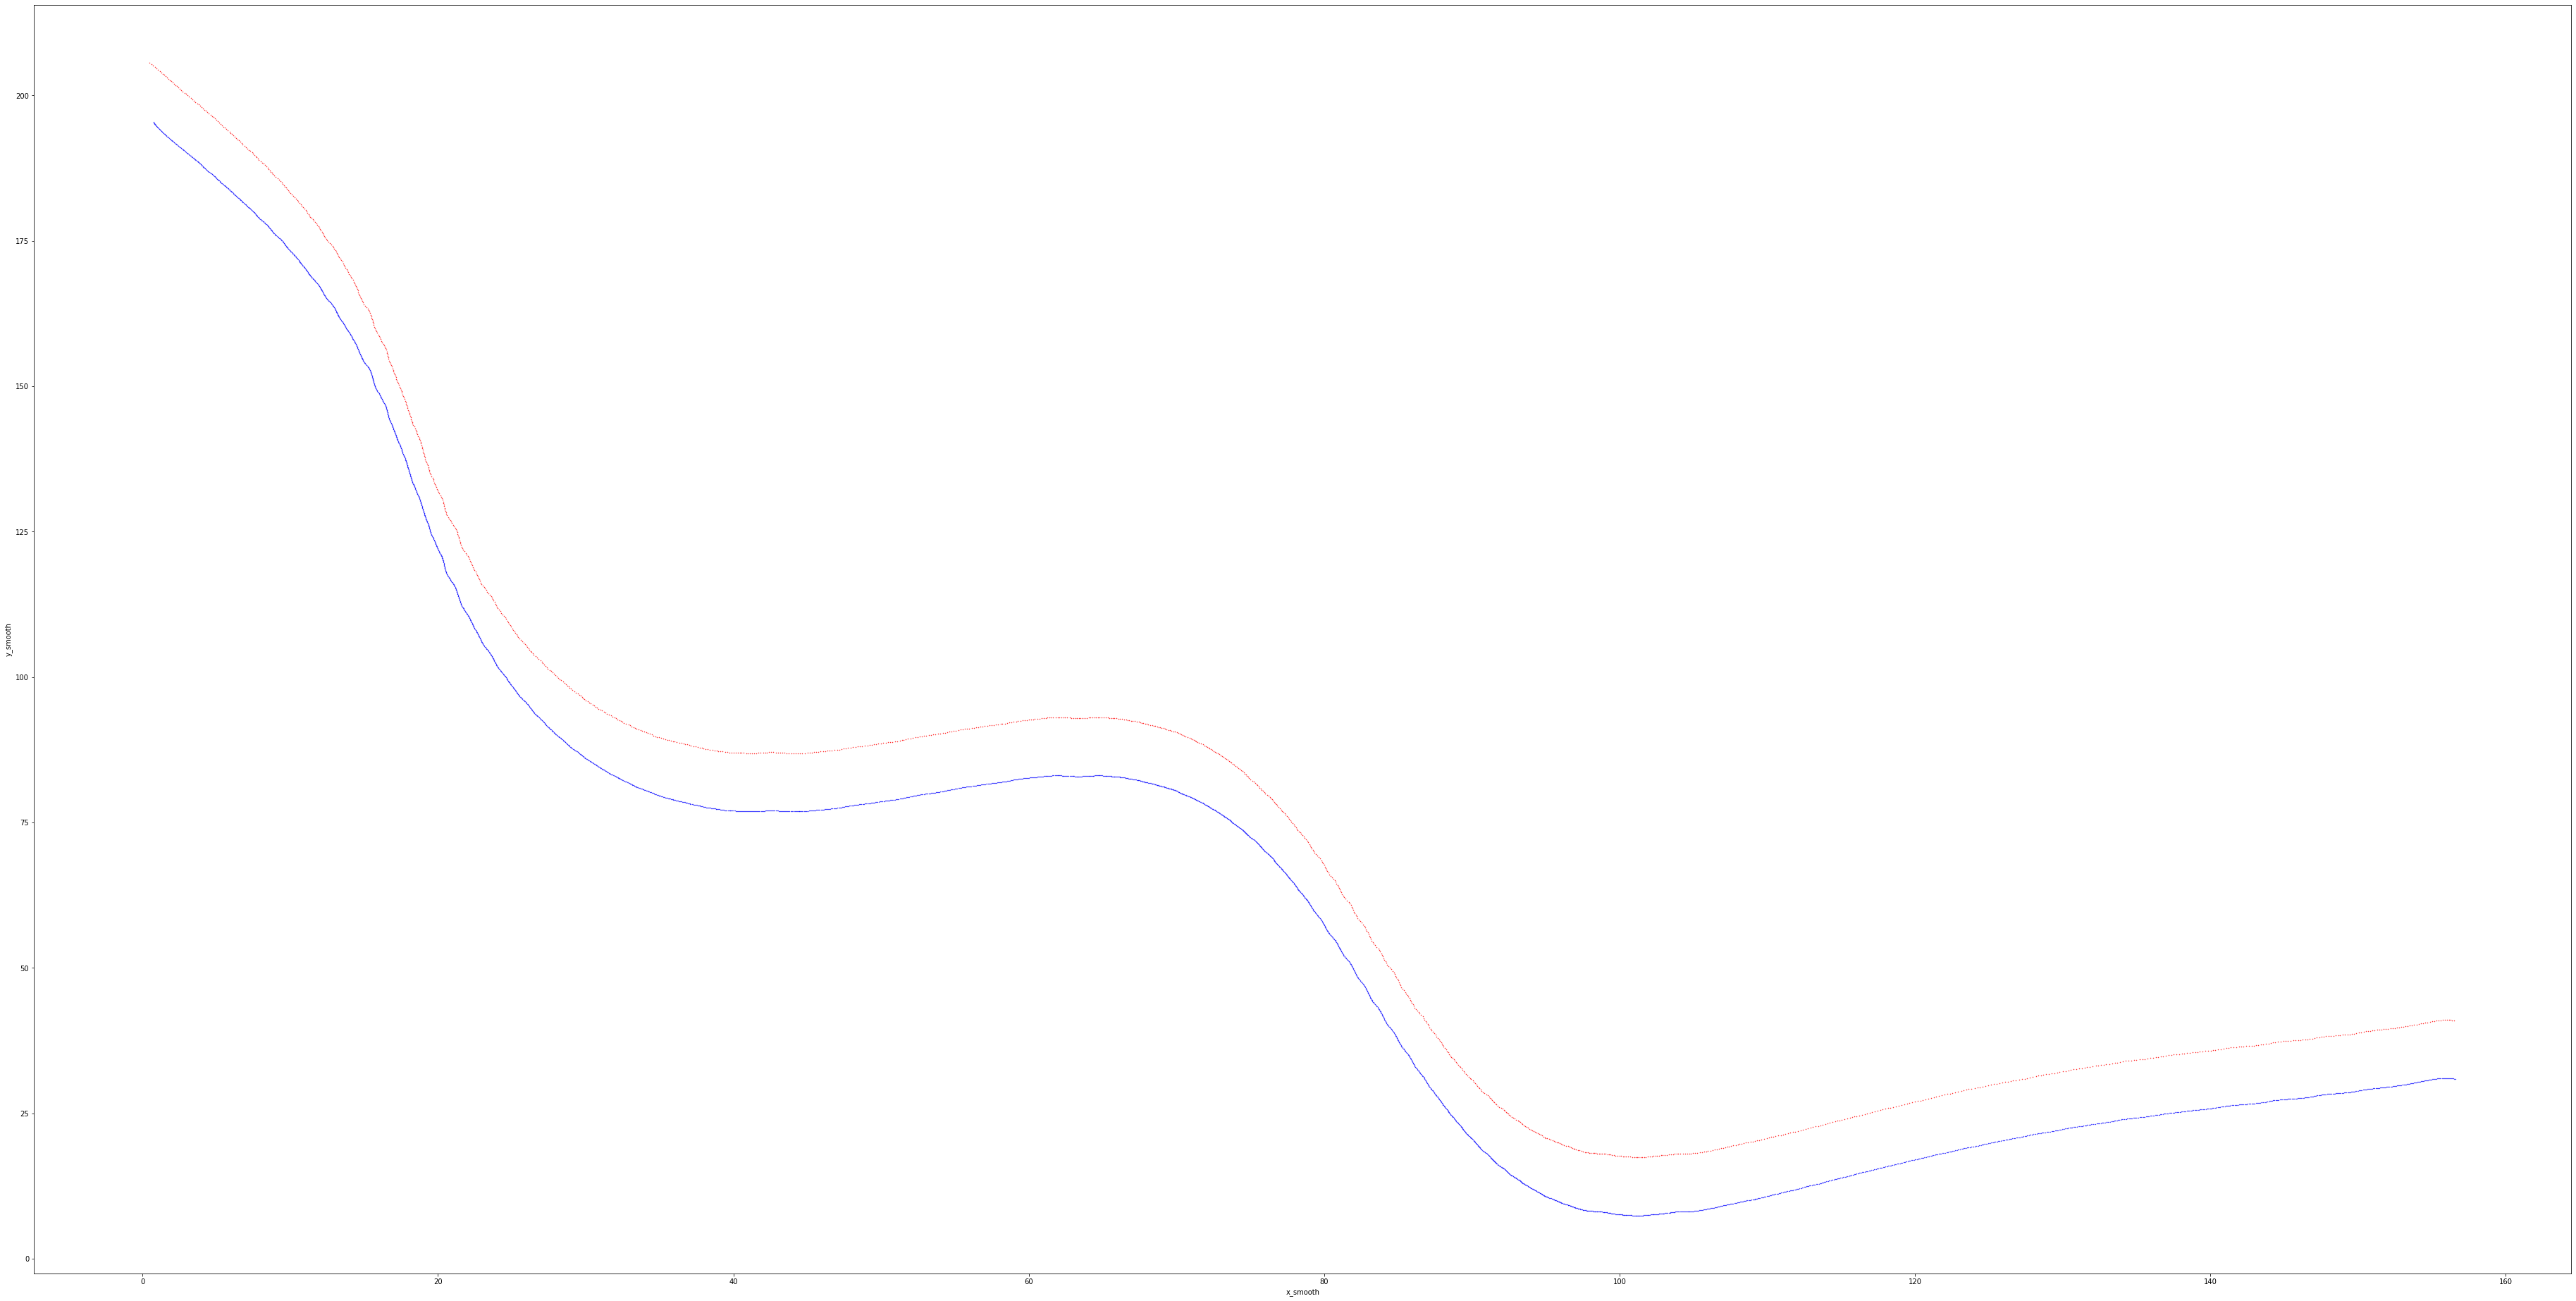

In [38]:
#zoom in, plot together

data1 = data_44_ctrl
data2 = data_44_fr74
x1 = data1.X_smooth
y1 = data1.Y_smooth
x2 = data2.X_smooth
y2 = data2.Y_smooth
fig=plt.figure(figsize = (50,25))
ax=fig.add_axes([0,0,1,1])
ax.scatter(x1, y1+10, color='r', s = 0.2)
ax.scatter(x2, y2, color='b', s = 0.1)
ax.set_xlabel('x_smooth')
ax.set_ylabel('y_smooth')
plt.show()

In [39]:
def zerolist(n):
    listofzeros = [0] * n
    return listofzeros

def add_x_dif(data):
    k = len(data)
    x_d = zerolist(k)
    for i in range(k):
        if i == 0:
            x_d[i] = data.loc[i, 'X_smooth']
        else:
            x_d[i] = data.loc[i, 'X_smooth'] - data.loc[i-1, 'X_smooth']
    data['x_difference'] = x_d
    
def add_y_dif(data):
    k = len(data)
    y_d = zerolist(k)
    for i in range(k):
        if i == 0:
            y_d[i] = data.loc[i, 'Y_smooth']
        else:
            y_d[i] = data.loc[i, 'Y_smooth'] - data.loc[i-1, 'Y_smooth']
    data['y_difference'] = y_d


In [40]:
#differences in velocity and curvature are responsible for high BDD

add_x_dif(data_44_ctrl)
add_y_dif(data_44_ctrl)

add_x_dif(data_44_fr74)
add_y_dif(data_44_fr74)



In [41]:
data_44_fr74

,Unnamed: 0,X,Y,X_smooth,Y_smooth,x_difference,y_difference
0,0,0,196,0.730784,195.447753,0.730784,195.447753
1,1,1,195,0.747966,195.383432,0.017181,-0.064321
2,2,1,195,0.765906,195.318485,0.017940,-0.064947
3,3,1,195,0.784585,195.252937,0.018679,-0.065548
4,4,1,195,0.803985,195.186809,0.019399,-0.066127
...,...,...,...,...,...,...,...
4315,4315,156,31,156.406877,30.995880,0.051052,-0.017037
4316,4316,156,31,156.458212,30.976501,0.051335,-0.019378
4317,4317,157,31,156.509846,30.954695,0.051634,-0.021807
4318,4318,157,31,156.561794,30.930371,0.051948,-0.024323


In [42]:
user_path = '/Users/karolinagrzeszkiewicz/robustness-tests/locomotion/tests/robustness_tests/results/'
#folder: FR_test_higher, FR_test_lower, density_test_higher, density_test_lower
def read_curve_42_trial_dat(folder, trial):
    #trial must be a double-digit string (also trial can be = "CTRL")
    name_of_dat = 'CRV_42_TEST_' + trial +'.dat'
    path_to_dat = user_path +folder+'/'+name_of_dat
    data = pd.read_csv(path_to_dat)
    return(data)

data_42_ctrl = read_curve_42_trial_dat("FR_test_higher", "CTRL")
data_42_fr74 = read_curve_42_trial_dat("FR_test_higher", "24")

x_ctrl_smooth = smooth(data_42_ctrl.X, 24)
type(x_ctrl_smooth)
len(x_ctrl_smooth)
x_ctrl_smooth.tolist()
data_42_ctrl['X_smooth'] = x_ctrl_smooth

x_74_smooth = smooth(data_42_fr74.X, 74)
len(x_74_smooth)
x_74_smooth.tolist()
data_42_fr74['X_smooth'] = x_74_smooth

y_ctrl_smooth = smooth(data_42_ctrl.Y, 24)
y_ctrl_smooth.tolist()
data_42_ctrl['Y_smooth'] = y_ctrl_smooth

y_74_smooth = smooth(data_42_fr74.Y, 74)
y_74_smooth.tolist()
data_42_fr74['Y_smooth'] = y_74_smooth

In [43]:
add_x_dif(data_42_ctrl)
add_y_dif(data_42_ctrl)

add_x_dif(data_42_fr74)
add_y_dif(data_42_fr74)

In [44]:
max(data_42_ctrl['x_difference'])

138.680561770329

(-0.6252100316627036, 0.42751866517261305)

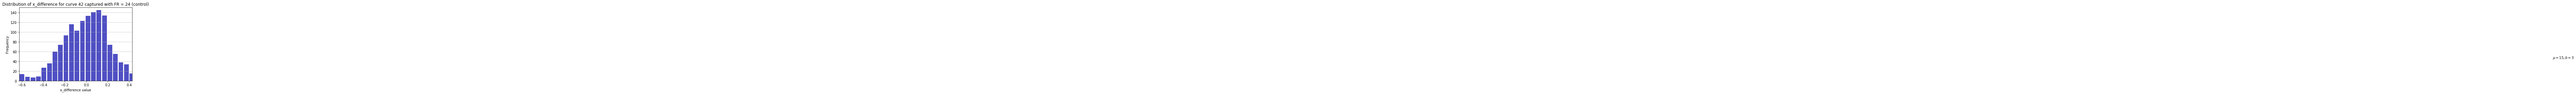

In [45]:
import matplotlib.pyplot as plt

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x= data_42_ctrl['x_difference'], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('x_difference value')
plt.ylabel('Frequency')
plt.title('Distribution of x_difference for curve 42 captured with FR = 24 (control)')
plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
new_data = data_42_ctrl.loc[1:,:]
x_max = max(new_data['x_difference'])
x_min = min(new_data['x_difference'])
plt.xlim(xmax = x_max, xmin= x_min)

(0.0, 150.0)

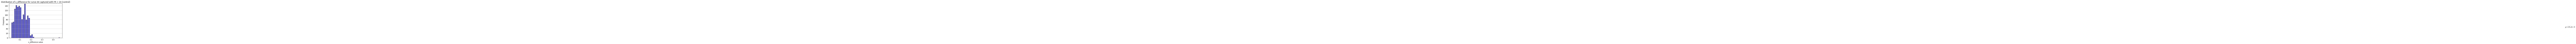

In [46]:
# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x= data_44_ctrl['x_difference'], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('x_difference value')
plt.ylabel('Frequency')
plt.title('Distribution of x_difference for curve 44 captured with FR = 24 (control)')
plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [47]:
def getHist(data, var):
    # An "interface" to matplotlib.axes.Axes.hist() method
    n, bins, patches = plt.hist(x= data[var+'_difference'], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel(var+'_difference value')
    plt.ylabel('Frequency')
    plt.title('Distribution of ' + var +'_difference for '+str(data))
    plt.text(23, 45, r'$\mu=15, b=3$')
    maxfreq = n.max()
     # Set a clean upper y-axis limit.
    plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
    new_data = data.loc[1:,:]
    x_max = max(new_data[var+ '_difference'])
    x_min = min(new_data[var + '_difference'])
    plt.xlim(xmax = x_max, xmin= x_min)
    plt.show()



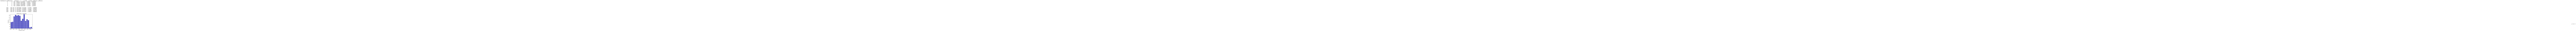

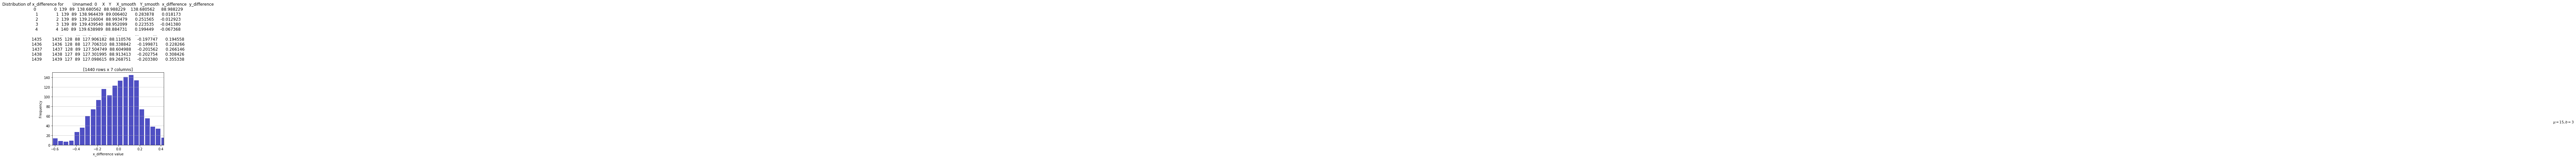

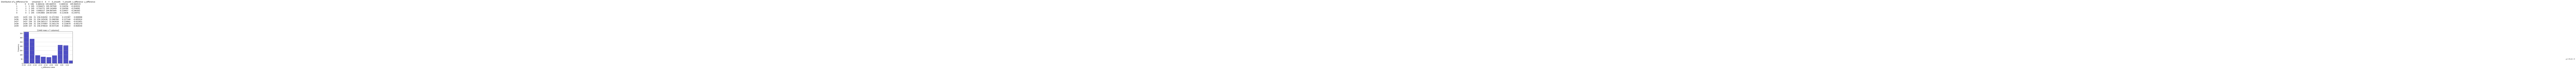

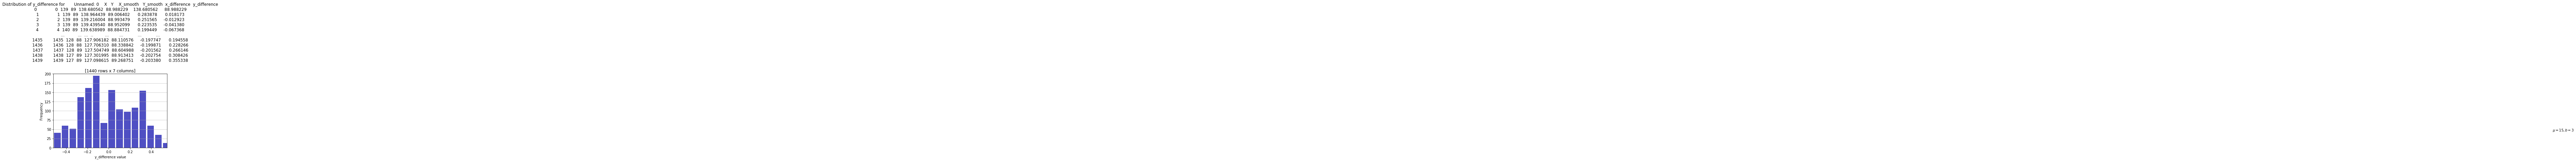

In [48]:
getHist(data_44_ctrl, 'x')
getHist(data_42_ctrl, 'x')

getHist(data_44_ctrl, 'y')
getHist(data_42_ctrl, 'y')
# curve 44 has smaller variability in x and y difference, but most differences have larger absolute value

In [49]:
def getDifScatterPlot(data, var):
    # An "interface" to matplotlib.axes.Axes.hist() method
    y = data[var+'_difference']
    x = data['Unnamed: 0']
    plt.scatter(x, y)
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('frame #')
    plt.ylabel(var+'_difference value')
    plt.title('Distribution of ' + var +'_difference for '+str(data))
    plt.xlim(xmin = 0, xmax = len(data))
    new_data = data.loc[1:,:]
    y_max = max(new_data[var+ '_difference'])
    plt.ylim(ymin = min(data[var+'_difference']), ymax = y_max)
    plt.show()

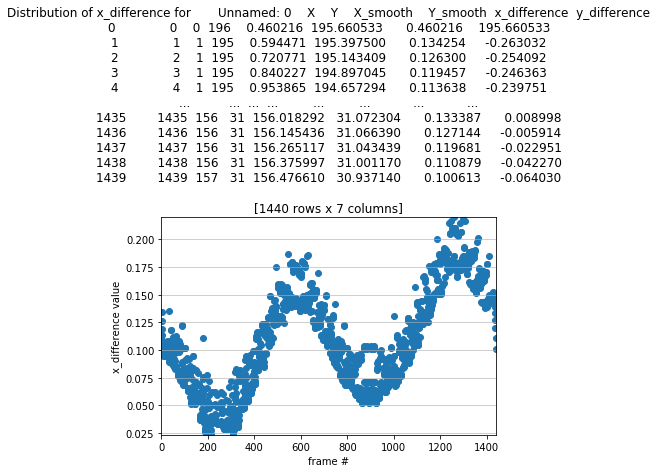

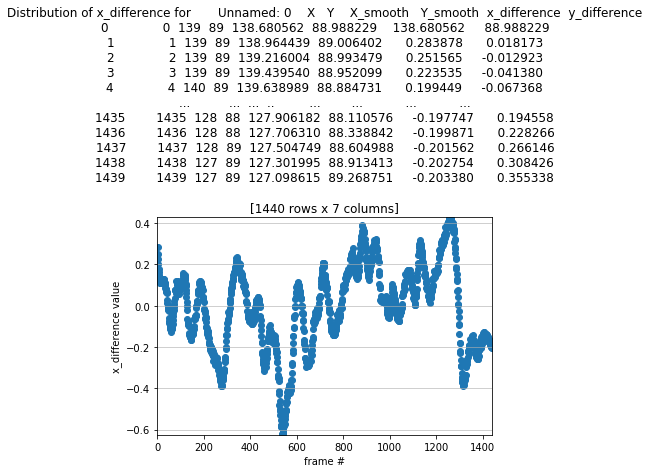

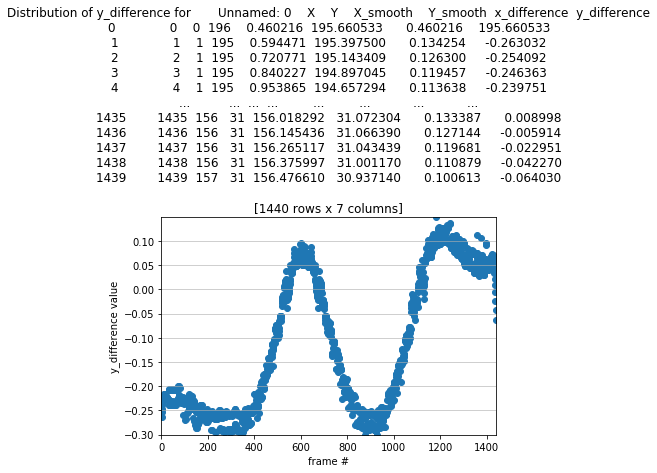

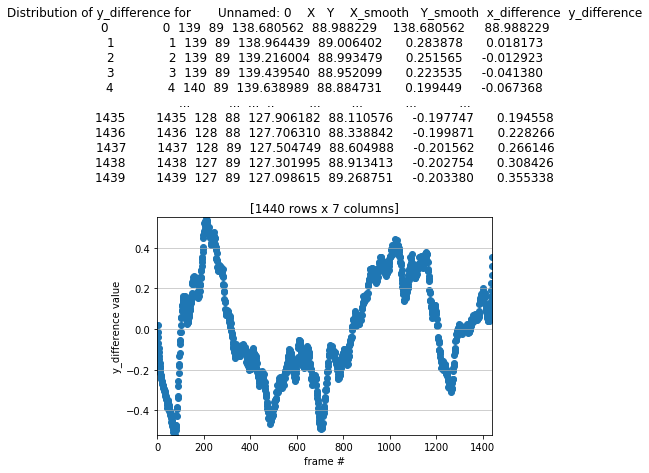

In [50]:
getDifScatterPlot(data_44_ctrl, 'x')
getDifScatterPlot(data_42_ctrl, 'x')

getDifScatterPlot(data_44_ctrl, 'y')
getDifScatterPlot(data_42_ctrl, 'y')

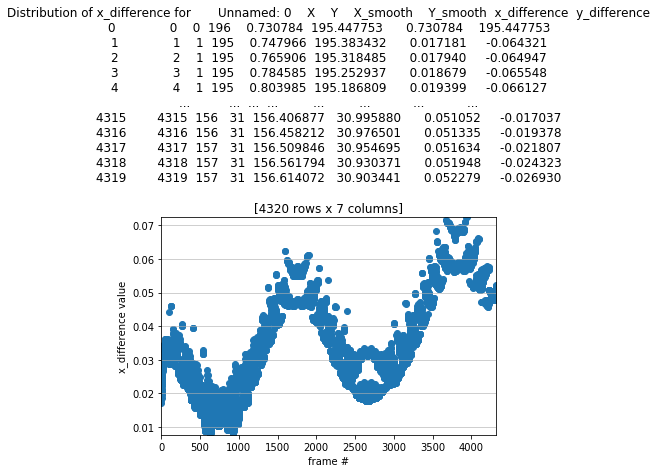

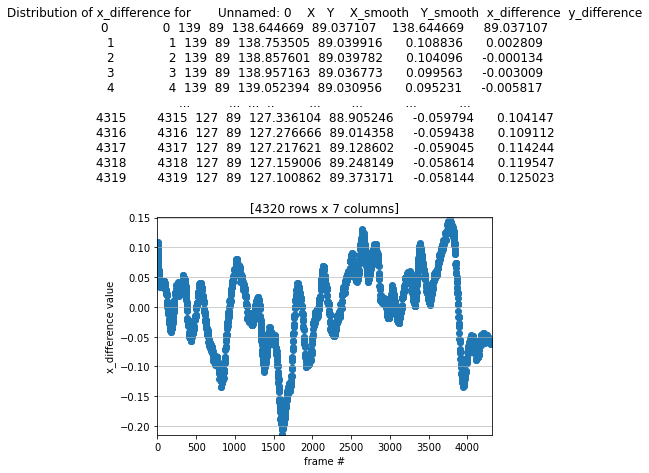

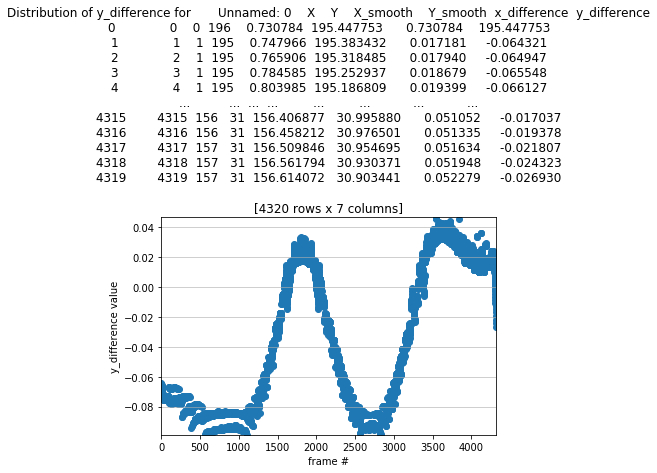

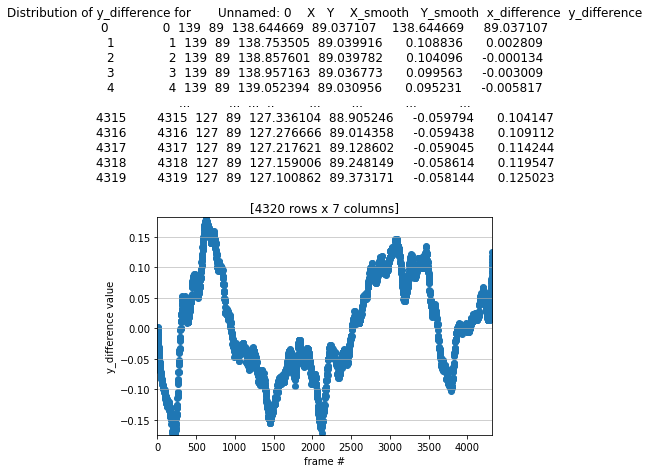

In [51]:
getDifScatterPlot(data_44_fr74, 'x')
getDifScatterPlot(data_42_fr74, 'x')

getDifScatterPlot(data_44_fr74, 'y')
getDifScatterPlot(data_42_fr74, 'y')

In [52]:
#as we go from fr = 24 to fr = 74 for curve 44 the x-dif range decreases from 0.20 to 0.07, y-dif from 0.4 to 0.14, ...
#(approximately by a factor of 3 which is what we expect)
#but plots thicken since we have more data points, so there is even more local variability 
#(for x-dif, y-dif, and thus velocity)
#so for frames (ca. 3 at a time = 4420/1440) when velocity in control curve stays constant, 
#velocity in curve with fr = 74 varies a lot (going up and down)
#whereas in other curves (such as curve 42): the change in velocity at a local point is more consistent 
#(when control stays constant fr = 74 curve just goes in one, more predictable direction)

In [53]:
#curve 44 velocity-alignments graphs
#Lower: 00 dip 160-280, 310-400, 430-530, 1200-1340, 01 big dip 100-430 (40-130), 07 small dip 200-330 (from 10 to 17 straight lines)
#higher: very small dips in a few places, eg 29 200-300, 1260-, trial_34 fr 200-400, 44 1260-
#so dips in similar places, there is some pattern
#curve 42 is generally smoother (e.g. higher test 29)

In [54]:
data_42_fr74

,Unnamed: 0,X,Y,X_smooth,Y_smooth,x_difference,y_difference
0,0,139,89,138.644669,89.037107,138.644669,89.037107
1,1,139,89,138.753505,89.039916,0.108836,0.002809
2,2,139,89,138.857601,89.039782,0.104096,-0.000134
3,3,139,89,138.957163,89.036773,0.099563,-0.003009
4,4,139,89,139.052394,89.030956,0.095231,-0.005817
...,...,...,...,...,...,...,...
4315,4315,127,89,127.336104,88.905246,-0.059794,0.104147
4316,4316,127,89,127.276666,89.014358,-0.059438,0.109112
4317,4317,127,89,127.217621,89.128602,-0.059045,0.114244
4318,4318,127,89,127.159006,89.248149,-0.058614,0.119547


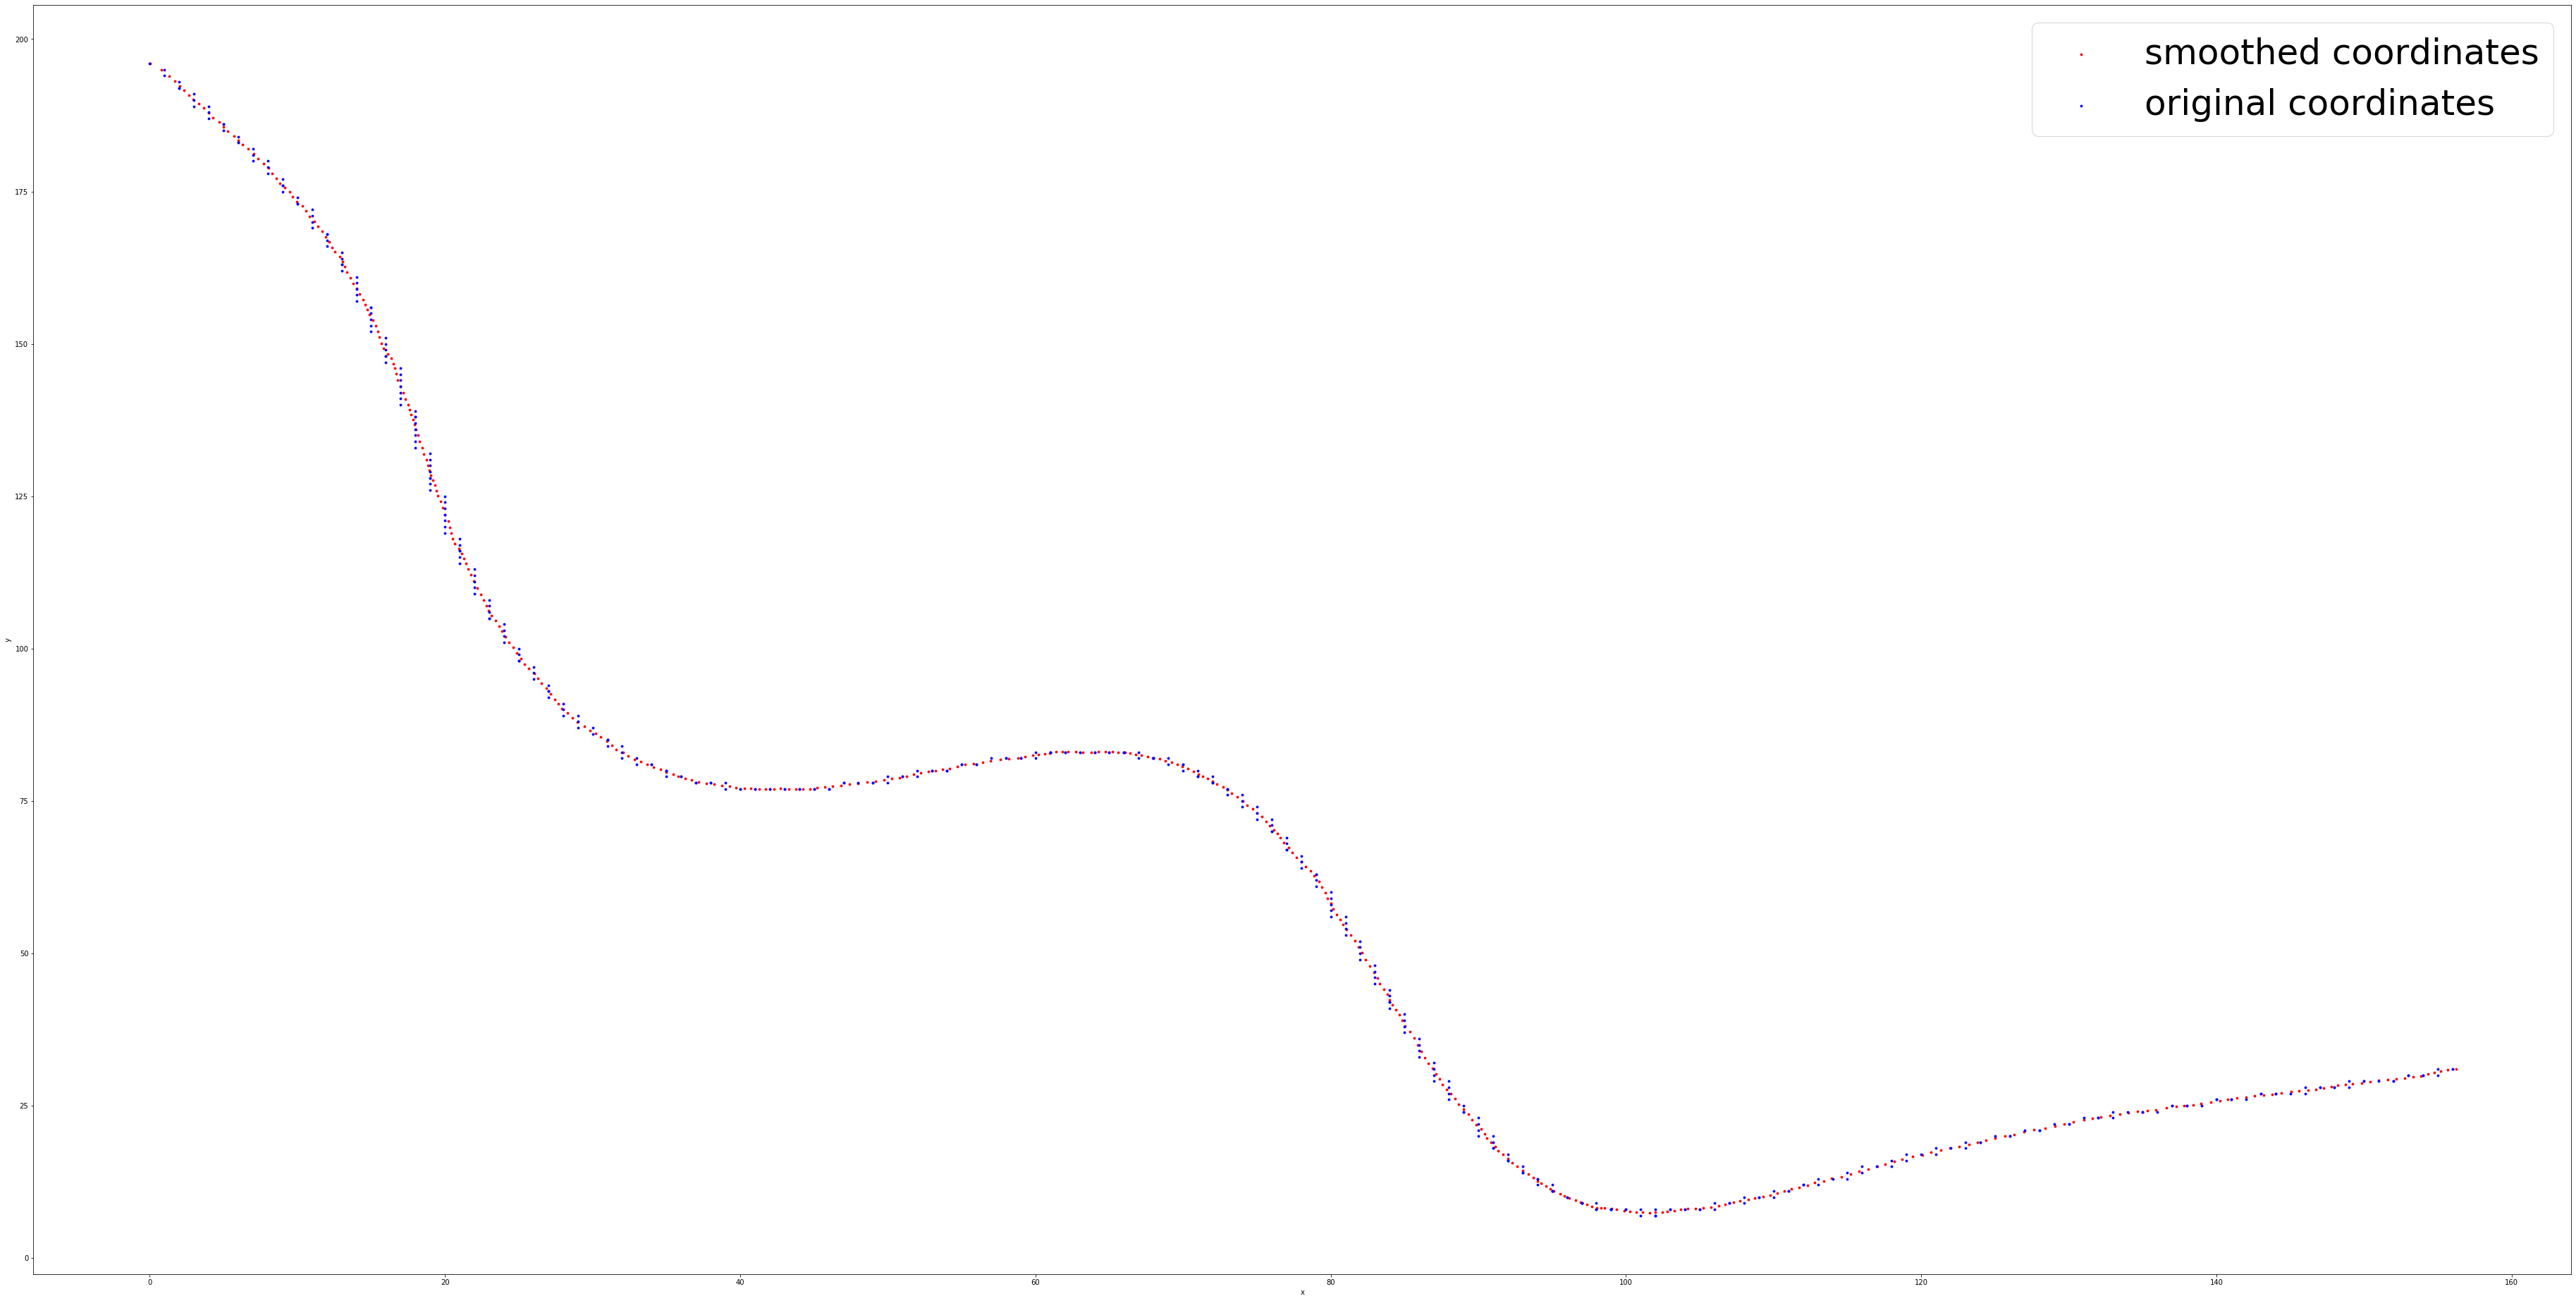

In [75]:
user_path = '/Users/karolinagrzeszkiewicz/robustness-tests/locomotion/tests/robustness_tests/results/'
#folder: FR_test_higher, FR_test_lower, density_test_higher, density_test_lower
def read_curve_44_trial_dat(folder, trial):
    #trial must be a double-digit string (also trial can be = "CTRL")
    name_of_dat = 'CRV_44_TEST_' + trial +'.dat'
    path_to_dat = user_path +folder+'/'+name_of_dat
    data = pd.read_csv(path_to_dat)
    return(data)

data_44_fr7 = read_curve_44_trial_dat("FR_test_lower", "01")

#before that savitzky golai smoothing must be included in the code, or taken from locomotion.trajectory
x_smooth = smooth(data_44_fr7.X, 7) #frame rate, take from the fr sequence
len(x_smooth)
x_smooth.tolist()
data_44_fr7['X_smooth'] = x_smooth

#check the distances between the points, this determines curvature as well

y_smooth = smooth(data_44_fr7.Y, 7)
y_smooth.tolist()
data_44_fr7['Y_smooth'] = y_smooth

#multiply len(data) (n of frames) by frame rate to have the same range regardless of fr of the curve
#for fr=24 the dip is fr24 = 100-430, 
#nah give frames for a particular curve
#zoomin = range(35, 140)
zoomin = range(len(data_44_fr7))

data1 = data_44_fr7.iloc[zoomin[0]:zoomin[-1]]
x1 = data1.X_smooth
y1 = data1.Y_smooth
x2 = data1.X
y2 = data1.Y
fig=plt.figure(figsize = (50,25))
ax=fig.add_axes([0,0,1,1])
ax.scatter(x1, y1, color='r', s = 8, label = 'smoothed coordinates')
ax.scatter(x2, y2, color='b', s = 8, label = 'original coordinates')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.legend(prop={'size': 50})
plt.show()

In [79]:
FR_high_sequence = []
for i in range(24, 120, 2):
    FR_high_sequence.append(i)
    
FR_low_sequence = []
for i in range(6, 24, 1):
    FR_low_sequence.append(i)
    
FR_low_sequence.index(8)
    
FR_high_sequence.index(24)

0

In [102]:
#the plotting functions are for frame rate robustness test
#to be provided by the user

FR_high_sequence = []
for i in range(24, 120, 2):
    FR_high_sequence.append(i)
    
FR_low_sequence = []
for i in range(6, 24, 1):
    FR_low_sequence.append(i)

path_to_results_folder = '/Users/karolinagrzeszkiewicz/robustness-tests/locomotion/tests/robustness_tests/results/'

#def PlotCurve(data1, data2 = None, mode = 'original', zoom_in_for_fr_range = range(0, len(data))):
#mode = 'original', 'smooth' ('smooth difference'?)
#we want to zoom in per particular frame rate range
#data variables: (density/FR), (higher/lower), curve, FR

def PlotCurve(curve, FR, mode = 'original', zoom_in_for_fr_range=None, FR2 = None, zoom_in_for_fr2_range = None):
    
    #plots x and y coordinates of curve (curve) with given frame rate (FR) and for a given range of frames (full range by default)
    #mode: 'original' (plots the original x and y coordinates)
    #/'smooth'(plots the x and y coordinates after applying Savitzky_golai smoothing)
    #/'both' (plots both original and smoothed coordinates)
    #provide FR2 as argument to plot the same curve but for different frame rate, 
    #provide  zoom_in_for_fr2_range to specify the frame range for the extra plot
    
    if zoom_in_for_fr_range is None:
        zoom_in_for_fr_range = range(0, FR*60)
    
    #obtain relevant data frame for given curve and FR
    def get_data(c, fr):
        curve_str = '%02d' % c
        if fr<24:
            test = 'lower'
            trial = FR_low_sequence.index(fr)
        elif fr<119:
            test = 'higher'
            trial = FR_high_sequence.index(fr)
        trial_str = '%02d' % trial
        name_of_dat = 'CRV_' +curve_str+ '_TEST_' + trial_str +'.dat'
        folder = 'FR_test_'+test
        path_to_dat = path_to_results_folder +folder+'/'+name_of_dat
        data = pd.read_csv(path_to_dat)
        return(data)
    
    data = get_data(curve, FR)
    
    #change the range of frames depending on which time/frame interval we want to zoom in to
    data = data.iloc[zoom_in_for_fr_range[0]:zoom_in_for_fr_range[-1], :]
    
    #set plot size and axis
    fig=plt.figure(figsize = (50,25))
    ax=fig.add_axes([0,0,1,1])
    
    if mode == 'original':
        ax.scatter(data.X, data.Y, color='b', s = 8, label = 'original coordinates, FR =' + str(FR))
    else:
        x_smooth = smooth(data.X, FR)
        y_smooth = smooth(data.Y, FR)
        x_smooth.tolist()
        y_smooth.tolist()
        data['X_smooth'] = x_smooth
        data['Y_smooth'] = y_smooth
        if mode == 'smooth':
            ax.scatter(data.X_smooth, data.Y_smooth, color='r', s = 8, label = 'smoothed coordinates, FR =' + str(FR))
        elif mode == 'both':
            ax.scatter(data.X_smooth, data.Y_smooth, color='r', s = 8, label = 'smoothed coordinates, FR =' + str(FR))
            ax.scatter(data.X, data.Y, color='b', s = 8, label = 'original coordinates')
            

    #optional: add the plot(s) for the second frame rate 
    if FR2 != None:
        data2 = get_data(curve, FR2)
        
        if zoom_in_for_fr2_range != None:
            data2 = data2.iloc[zoom_in_for_fr2_range[0]:zoom_in_for_fr2_range[-1], :]
        else:
            data2 = data2.iloc[0:len(data2), :]

        if mode == 'original':
            ax.scatter(data2.X, data2.Y, color='g', s = 8, label = 'original coordinates, FR =' + str(FR2))
        else:
            x_smooth2 = smooth(data2.X, FR)
            y_smooth2 = smooth(data2.Y, FR)
            x_smooth2.tolist()
            y_smooth2.tolist()
            data2['X_smooth'] = x_smooth2
            data2['Y_smooth'] = y_smooth2
            if mode == 'smooth':
                ax.scatter(data2.X_smooth, data2.Y_smooth, color='o', s = 8, label = 'smoothed coordinates, FR =' + str(FR2))
            elif mode == 'both':
                ax.scatter(data.X_smooth, data.Y_smooth, color='r', s = 8, label = 'smoothed coordinates, FR =' + str(FR2))
                ax.scatter(data2.X, data2.Y, color='g', s = 8, label = 'original coordinates, FR =' + str(FR2))       
        
    #add labels and legend
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.legend(prop={'size': 50})

    plt.show()
        
        
            
        
            
        
    
  


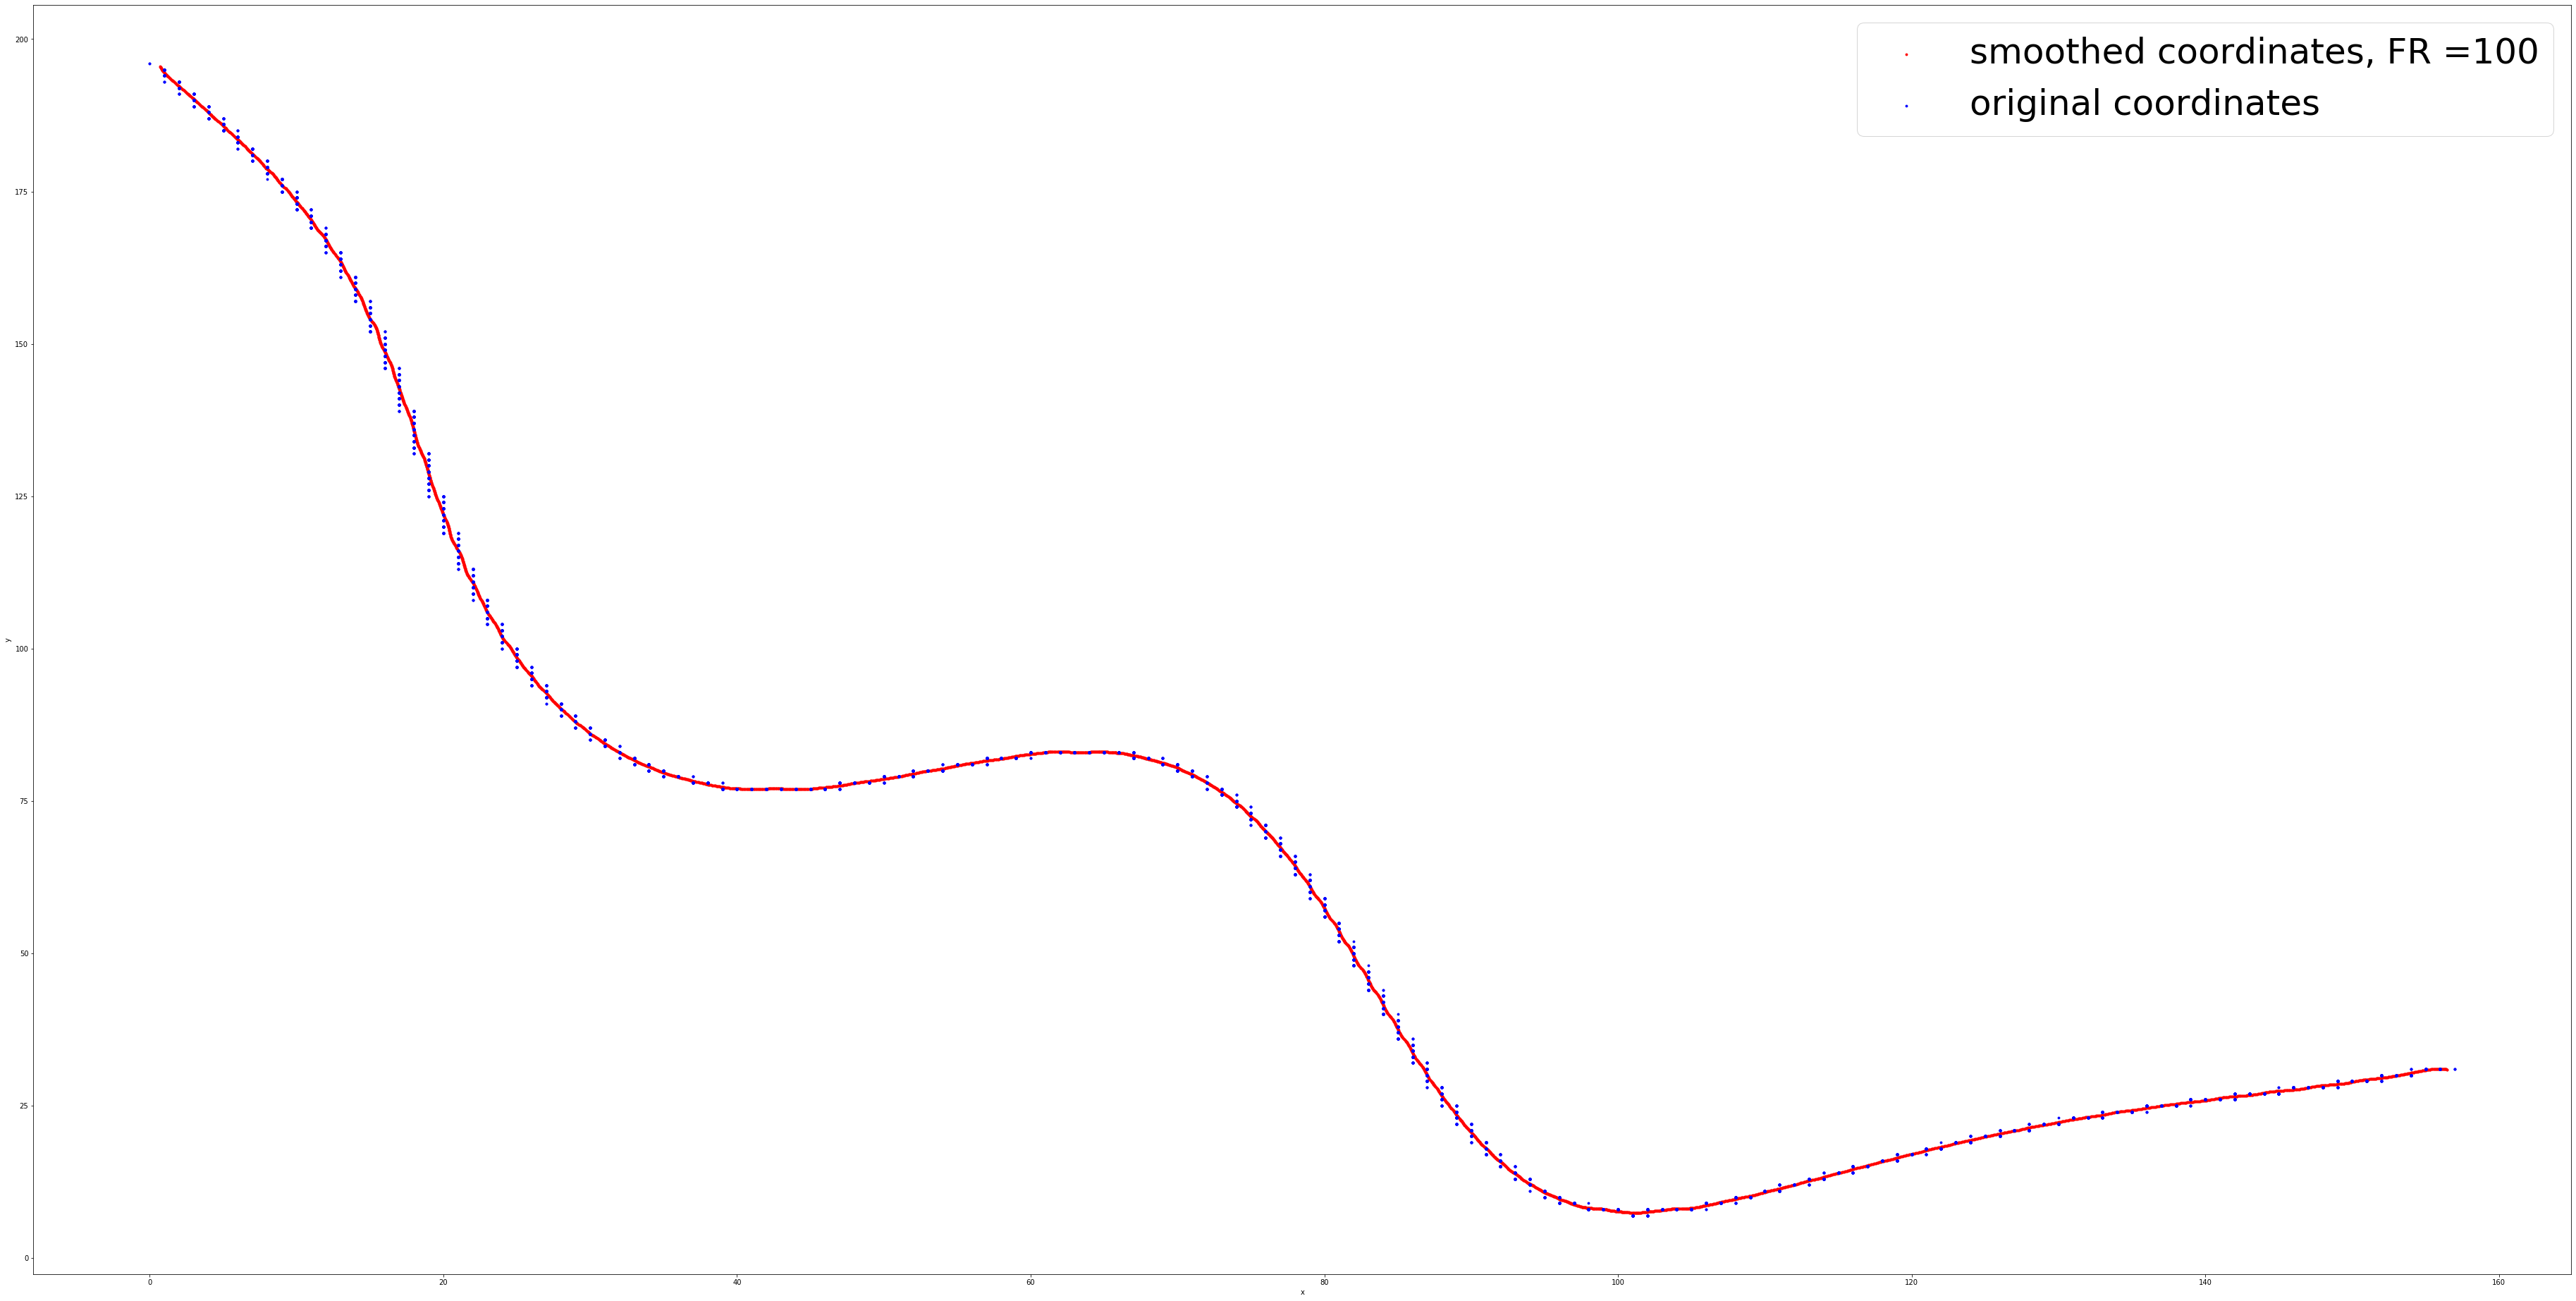

In [109]:
PlotCurve(44, 100, mode = 'both', FR2 = None, zoom_in_for_fr2_range = None)